# Project introduction and explanation

Overpass API - serves up custom selected parts of the OSM map data.

# Necessary imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install osmnx
!pip install overpy
!pip install contextily

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import osmnx as ox
import pyproj
import overpy
import time
import contextily as ctx
from shapely.ops import unary_union, polygonize
from shapely.geometry import Point, LineString, Polygon

import matplotlib.pyplot as plt

In [ ]:
class HandleCycleData:
    def __init__(self, city="Tartu"):
        self.city = ox.features_from_place(f"{city}, Estonia", tags = {'name': f'{city} linn', 'type': 'boundary'})
        self.city_graph = None
        self.nodes, self.edges, self.filtered_edges = None, None, None
    def check(self, highway):
        cycle = ['cycleway']
        if isinstance(highway, list):
            return any(value in highway for value in cycle)
        else:
            return highway in cycle

    def get_cycling_data(self):
        self.city = self.city.query("name == 'Tartu linn' and admin_level == '9'")
        self.crs_web = pyproj.CRS.from_epsg('3857')
        self.crs_gps = pyproj.CRS.from_epsg('4326')

        polygon = unary_union(list(self.city.to_crs(crs=self.crs_gps).geometry))
        self.city_graph = ox.graph_from_polygon(polygon)

        self.nodes, self.edges = ox.graph_to_gdfs(self.city_graph)
        self.mask = self.edges['highway'].apply(self.check)
        self.filtered_edges = self.edges[self.mask]
        return self.filtered_edges, polygon

    def plot_filtered_graph(self):
        temp = ox.graph_from_gdfs(self.nodes, self.filtered_edges)
        tartu_cyclable = self.city_graph.edge_subgraph(temp.edges)

        fig, ax = ox.plot_graph(tartu_cyclable, node_size = 3, edge_color = 'blue', figsize=(14,14))


In [ ]:
  class BikeData:
      def __init__(self, bike_data):
          self.bikes = pd.read_csv(bike_data)
          self.city_bikes = None

      def get_bike_locations(self, polygon):
          points = []
          locs = []
          for index, row in self.bikes.iterrows():
            points.append(Point(row['X'], row['Y']))
            locs.append(row['Asukoht'])

          d = {'geometry': points, 'location': locs}
          gdf_bikes = gpd.GeoDataFrame(d).set_crs('epsg:3301') # Estonian Coordinate System of 1997
          gdf_bikes = gdf_bikes.to_crs('epsg:4326') # WGS 84

          self.city_bikes = gdf_bikes[gdf_bikes.apply(lambda row: row['geometry'].within(polygon), axis=1)].reset_index()

      def plot_base_map(self, polygon, crs_gps, routes=None):
          from matplotlib.colors import ListedColormap # This is necessary to have all the points in the same color. Weird implementation, I know.
          mycolor = ListedColormap('blue')

          map_source = ctx.providers.OpenStreetMap.DE

          tartu_boundary = gpd.GeoDataFrame(geometry=[polygon]).set_crs(epsg='4326')
          ax = tartu_boundary.plot(edgecolor='red', facecolor='none', figsize=(14,14), alpha = 0.5)
          ctx.add_basemap(ax=ax, crs=crs_gps, source=map_source, zoom=15)

          cols = ['green', 'blue', 'orange']

          if routes:
            if len(routes) == 3:
              graph = ox.graph_from_polygon(polygon)
              ox.plot_graph_routes(graph, ax=ax, routes=routes, bgcolor='none', node_color='none', node_size=0,
                          edge_color='none', edge_linewidth=0, route_colors=cols, orig_dest_size=6,route_linewidth=1)
            elif len(routes) == 1:
              graph = ox.graph_from_polygon(polygon)
              ox.plot_graph_route(graph, ax=ax, route=routes[0], bgcolor='none', node_color='none', node_size=0,
                          edge_color='none', edge_linewidth=0, route_color="blue", orig_dest_size=6,route_linewidth=1)
          else:
            self.city_bikes.plot(ax=ax, column='geometry', cmap=mycolor)



In [ ]:
class BikeRouter:
    def __init__(self, bike_data_path):
        self.data_handler = HandleCycleData('Tartu')
        self.bike_data = BikeData(bike_data_path)
        self.filtered_edges, self.polygon = None, None

    def add_remaining_nodes(self):
        cols = ['osmid', 'highway', 'reversed', 'length', 'geometry']
        data = self.filtered_edges[cols]

        tartu_filled  = pd.DataFrame(data, columns=cols, index=self.filtered_edges.index)
        tartu_filled['weight'] = 1.0 # initially all are cycleways
        self.tartu_graph = ox.graph_from_polygon(self.polygon)

        self.nodes, self.edges = ox.graph_to_gdfs(self.tartu_graph)

        inverse_filtered = self.edges[~self.data_handler.mask]
        inverse_filtered = pd.DataFrame(inverse_filtered, columns=cols, index=inverse_filtered.index)
        inverse_filtered['weight'] = 1.5 # remaining classes have higher weight
        print("1.5 weight")

        self.tartu_filled = pd.concat([tartu_filled, inverse_filtered])
        self.tartu_filled['wlen'] = tartu_filled.apply(lambda row: row['length']*row['weight'], axis=1)

    def preprocess(self):
        self.filtered_edges, self.polygon  = self.data_handler.get_cycling_data()
        # self.data_handler.plot_filtered_graph()
        self.bike_data.get_bike_locations(self.polygon)
        # self.bike_data.plot_base_map(self.polygon, self.data_handler.crs_gps)
        self.add_remaining_nodes()

    def calculate_shortest_path(self):
        gdf = gpd.GeoDataFrame(self.tartu_filled)
        temp2 = ox.graph_from_gdfs(self.nodes, gdf)
        self.tartu_filled_cyclable = self.tartu_graph.edge_subgraph(temp2.edges)

        # Copy over the wlen attribute
        wlens = {}
        for i,j in self.tartu_filled.iterrows():
            wlens[i] = {'wlen': j['wlen']}

        nx.set_edge_attributes(self.tartu_filled_cyclable, wlens)

        # Add speed limits
        new_maxspeeds = {}
        for u,v,k,d in self.tartu_filled_cyclable.edges(keys=True, data=True):
            if 'maxspeed' not in d:
                new_maxspeeds[(u,v,k)] = {'maxspeed': 28}

        nx.set_edge_attributes(self.tartu_filled_cyclable, new_maxspeeds)

        # As we are going to use the "speed_kph" attribute later anyway,
        # let's use the automated method to set this attribute on all roads
        ox.speed.add_edge_speeds(self.tartu_filled_cyclable)

        # Get estimated travel times for all roads (with 28 km/h limit)
        self.tartu_filled_cyclable = ox.speed.add_edge_travel_times(self.tartu_filled_cyclable)

    def calculate_route(self, p1, p2, share):
        p1 = ox.geocode_to_gdf(p1)
        p2 = ox.geocode_to_gdf(p2)

        # Combine discovered building shapes, assign labels and path direction
        gdf_addr = gpd.GeoDataFrame(pd.concat([p1, p2])) \
            .assign(label=['Start', 'Stop'], path=['start', 'stop']) \
            .set_index('path') \
            .to_crs(crs=self.data_handler.crs_web)

        # Find coordinates of the two points
        lons, lats= np.vstack(gdf_addr.geometry.centroid.to_crs(crs=self.data_handler.crs_gps).apply(lambda gdf: np.asarray(gdf.xy).reshape(-1)).values).T

        # Find the closest nodes in a road graph
        (start, stop), dists = ox.nearest_nodes(self.tartu_filled_cyclable, lons, lats, return_dist=True)
        print(f'Closest road to P1: {round(dists[0],1)}m')
        print(f'Closest road to P2: {round(dists[1],1)}m')

        if share:
          gdf_parking = self.bike_data.city_bikes
          points = [Point(lon, lat) for lon, lat in zip(lons, lats)]
          source = points[0]
          dest = points[1]

          graph = ox.graph_from_polygon(self.polygon)

          dists_from_source = []
          dists_from_dest = []
          for point in gdf_parking['geometry']:
            dists_from_source.append(ox.distance.euclidean(source.y, source.x, point.y, point.x))
            dists_from_dest.append(ox.distance.euclidean(dest.y, dest.x, point.y, point.x))

          gdf_parking['dist_from_source'] = dists_from_source
          gdf_parking['dist_from_dest'] = dists_from_dest

          parking_source = gdf_parking.loc[gdf_parking['dist_from_source'].idxmin(), 'geometry']
          parking_dest = gdf_parking.loc[gdf_parking['dist_from_dest'].idxmin(), 'geometry']

          #Finding the nearest nodes to the points
          start_p, dist_start_p = ox.nearest_nodes(graph, parking_source.x, parking_source.y, return_dist=True)
          stop_p, dist_stop_p = ox.nearest_nodes(graph, parking_dest.x, parking_dest.y, return_dist=True)

          route_to_parking = ox.shortest_path(graph, start_p, start, weight='length', cpus=None)
          route = ox.shortest_path(self.tartu_filled_cyclable, start_p, stop_p, weight='wlen', cpus=None)
          route_from_parking = ox.shortest_path(graph, stop_p, stop, weight='length', cpus=None)

          return (route_to_parking, route, route_from_parking)

        else:
          # Calculate the route
          # Use length as the metric, use all processors available
          route = ox.shortest_path(self.tartu_filled_cyclable, start, stop, weight='wlen', cpus=None)
          return route

    def get_travel_time(self, routes):
        ttotal = 0.0
        for route in routes:
            for n1,n2 in zip(route, route[1:]):
                e = self.tartu_filled_cyclable.get_edge_data(n1,n2)
                # Add up the travel time for each road
                if 'travel_time' in e[0]:
                    ttotal += float(e[0]['travel_time'])

        return ttotal

    def plot_routes(self, routes):
        self.bike_data.plot_base_map(self.polygon, self.data_handler.crs_gps, routes)


# Gathering and cleaning the data

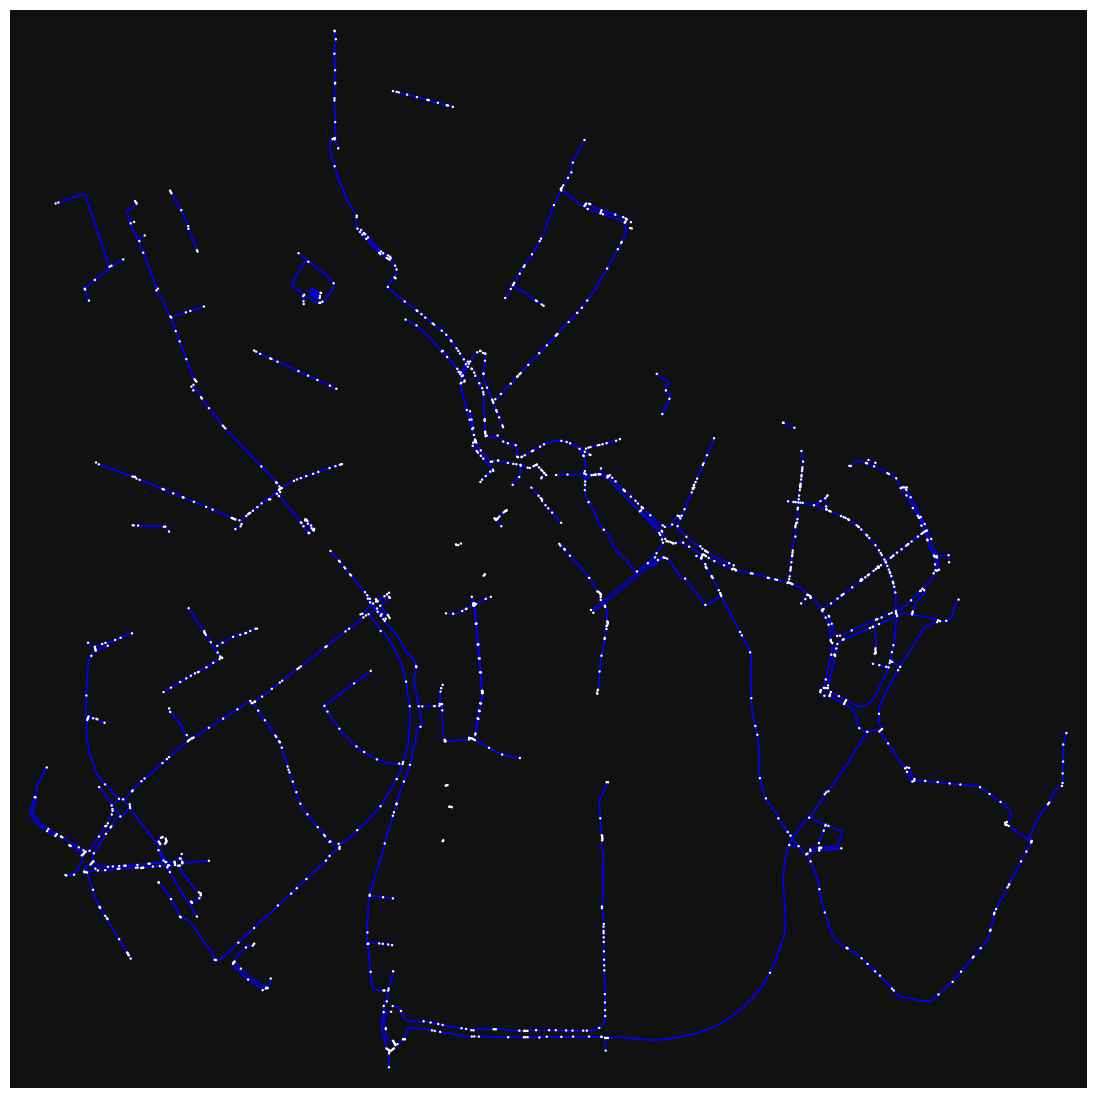

In [ ]:
data_handler = HandleCycleData('Tartu')
filtered_edges, polygon  = data_handler.get_cycling_data()
data_handler.plot_filtered_graph()

## Bikeshare parking data

In [ ]:
#bike_data = BikeData('/content/drive/MyDrive/Haridus/EIT Urban Mobility/UNIVERSITY OF TARTU/Intelligent Transportation Systems MTAT.08.040/ITS project/LI_rattaringluse_parklad_avaandmed.csv')
bike_data = BikeData('/content/drive/MyDrive/LI_rattaringluse_parklad_avaandmed.csv')
bike_data.get_bike_locations(polygon)
bike_data.bikes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X             Y  OBJECTID  Tyyp  Rataste_arv  \
0    659812.7173  6.472137e+06      6468     4         20.0   
1    657050.8884  6.474397e+06      6470     4         20.0   
2    660685.1453  6.474578e+06      6473     4         20.0   
3    660308.3754  6.474163e+06      6810     4         16.0   
4    661007.7723  6.473687e+06      6811     4         18.0   
..           ...           ...       ...   ...          ...   
97   653558.4336  6.467420e+06     14213     4         20.0   
98   653373.9683  6.471460e+06     14214     4         20.0   
99   659754.6889  6.476112e+06     14215     4          NaN   
100  658829.8833  6.478106e+06     14224     4          NaN   
101  663736.4301  6.473050e+06     14227     4         20.0   

                       Asukoht  Staatus  Linnaosa  \
0               79 E-kaubamaja        1       4.0   
1                76 Tartu Maja        1      16.0   
2                      72 Paju        1      17.0   
3                  10 Turusild        1       1.0   
4                  1 Kalda tee        1       1.0   
..                         ...      ...       ...   
97                  98 Külitse        1       NaN   
98                    99 Haage        1       NaN   
99               100 Kruusamäe        1       7.0   
100  101 HUUM/Vahi tööstuspark        1       NaN   
101     102 Lohkva Spordihoone        1       NaN   

                                   GlobalID  
0    {2FA3BB58-B903-4579-A422-993872536EC7}  
1    {AE8DAF75-298A-4DA5-B6D4-18B20BAF0B16}  
2    {50FC42DE-D278-4E75-9FFA-C58C281F2D15}  
3    {69A09375-0958-4619-857D-68F2152754A6}  
4    {E7A3E9E7-1B25-472F-8CDC-6C5F6E10376B}  
..                                      ...  
97   {EF926AEC-0EC9-4828-B484-D1DE22E05BE2}  
98   {69C541F4-8E04-47AA-8EF1-B25A3C3D2A99}  
99   {68B0866E-C768-4926-952C-E061F23B4D99}  
100  {C802DB68-AF56-45FF-B404-D4D43DE4B720}  
101  {4BEF1D9C-5EA6-4CA7-B977-F0A2A048E2C1}  

[102 rows x 9 columns]

In [ ]:
bike_data.city_bikes

index                   geometry           location
0       0  POINT (26.73099 58.36047)     79 E-kaubamaja
1       1  POINT (26.68539 58.38174)      76 Tartu Maja
2       2  POINT (26.74759 58.38205)            72 Paju
3       3  POINT (26.74087 58.37846)        10 Turusild
4       4  POINT (26.75248 58.37393)        1 Kalda tee
..    ...                        ...                ...
83     90  POINT (26.77963 58.37253)        4 Mõisavahe
84     91  POINT (26.74514 58.37849)            9 Papli
85     92  POINT (26.77509 58.37274)   5 Annelinna kiir
86     94  POINT (26.73094 58.38907)  94 Tehnikaülikool
87     99  POINT (26.73277 58.39615)      100 Kruusamäe

[88 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap

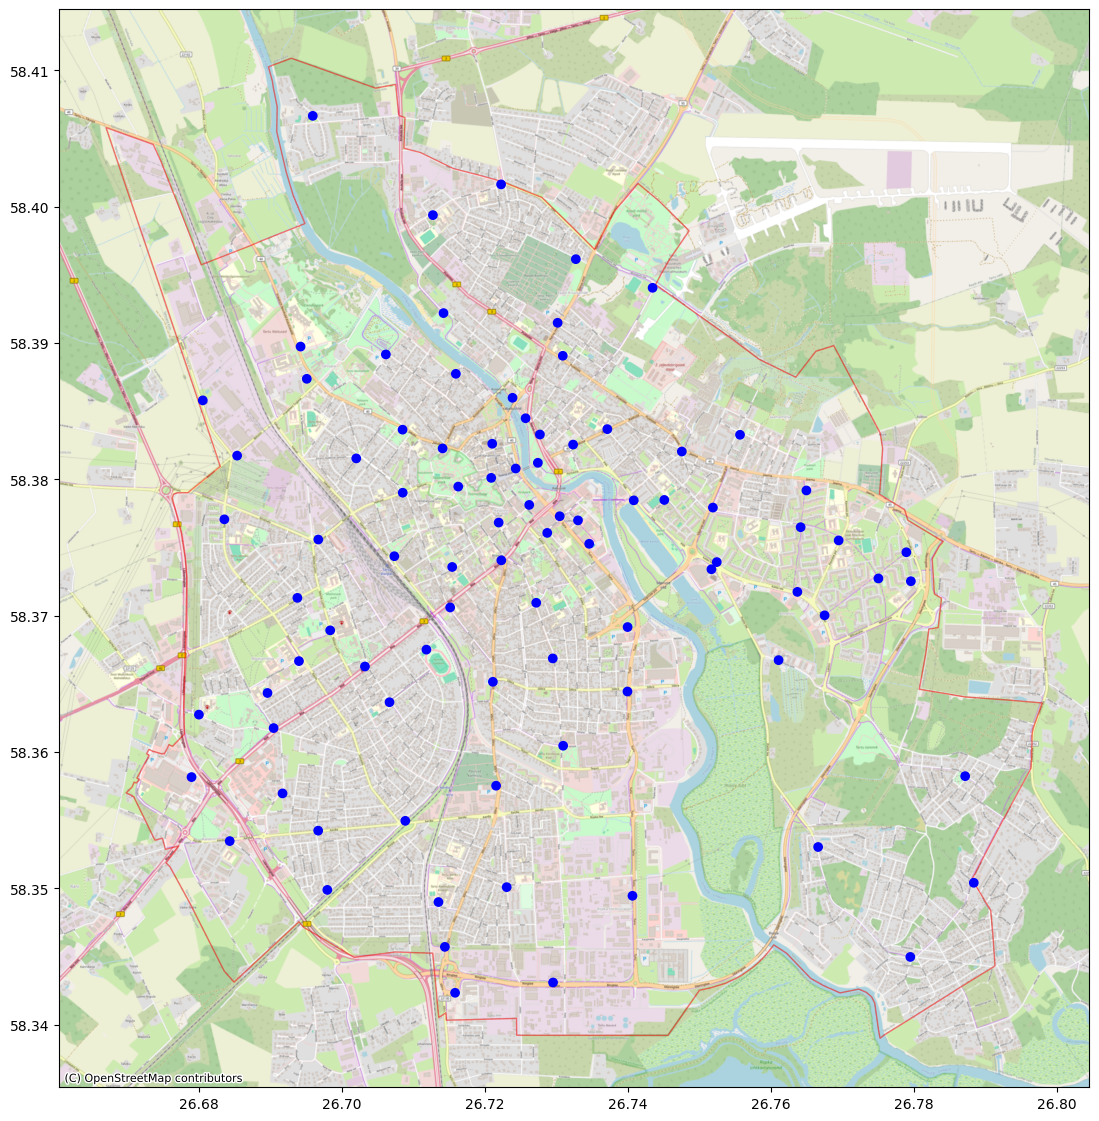

In [ ]:
bike_data.plot_base_map(polygon, data_handler.crs_gps)

# Path Search and Route Output

In [ ]:
#route_calculator = BikeRouter('/content/drive/MyDrive/Haridus/EIT Urban Mobility/UNIVERSITY OF TARTU/Intelligent Transportation Systems MTAT.08.040/ITS project/LI_rattaringluse_parklad_avaandmed.csv')
route_calculator = BikeRouter('/content/drive/MyDrive/LI_rattaringluse_parklad_avaandmed.csv')
route_calculator.preprocess()
route_calculator.calculate_shortest_path()
p1 = 'Narva mnt. 18, Tartu, Estonia'
p2 = 'Tehase 21, Tartu, Estonia'
route = route_calculator.calculate_route(p1, p2, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.5 weight
Closest road to P1: 5.5m
Closest road to P2: 30.3m


/usr/local/lib/python3.10/dist-packages/osmnx/routing.py:49: UserWarning: The attribute 'wlen' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


Closest road to P1: 53.0m
Closest road to P2: 26.7m


/usr/local/lib/python3.10/dist-packages/osmnx/routing.py:49: UserWarning: The attribute 'wlen' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


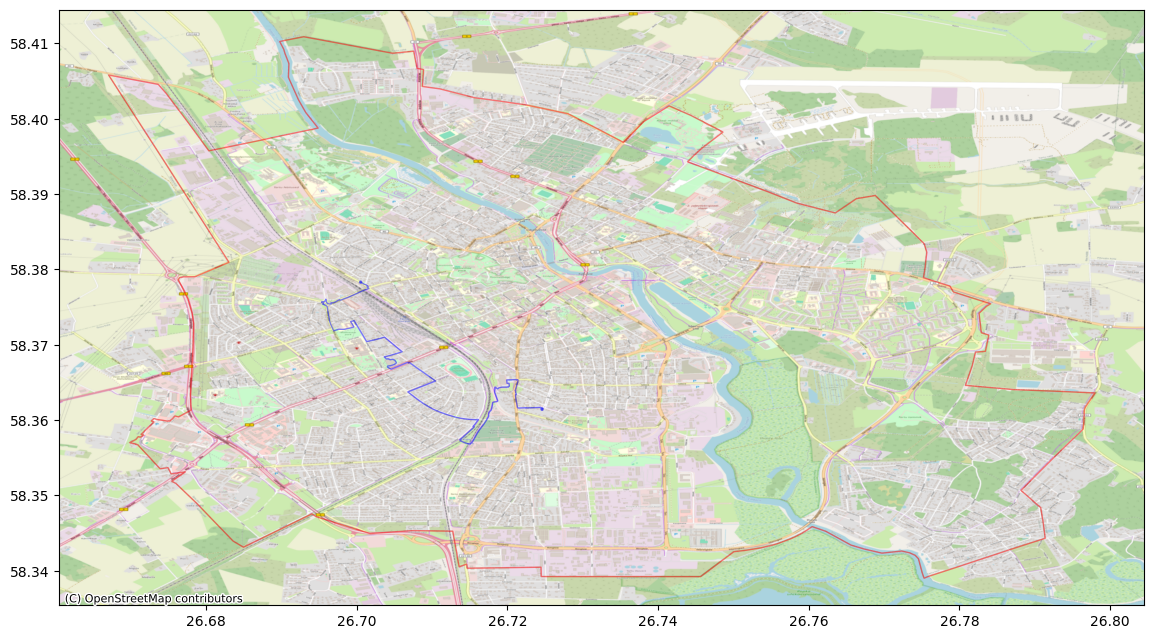

In [ ]:
#When share=True, then the return object will be a tuple with length 3

p1 = 'Vaksali 24, Tartu, Estonia'
p2 = 'Tehase 5, Tartu, Estonia'
route = route_calculator.calculate_route(p1, p2, False)
routes = [route]
route_calculator.plot_routes(routes)

In [ ]:
route_calculator.plot_routes([route])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Do you want to use bikeshare or personal bike? Write 'share' or 'personal'.personal
Your start location is: Ihaste põik 22, Tartu, Estonia
Your destination: Narva mnt. 18, Tartu, Estonia
Closest road to P1: 30.5m
Closest road to P2: 5.5m


/usr/local/lib/python3.10/dist-packages/osmnx/routing.py:49: UserWarning: The attribute 'wlen' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


Travel time 
From: Ihaste põik 22, Tartu, Estonia 
To: Narva mnt. 18, Tartu, Estonia 
Time: 23.25 minutes


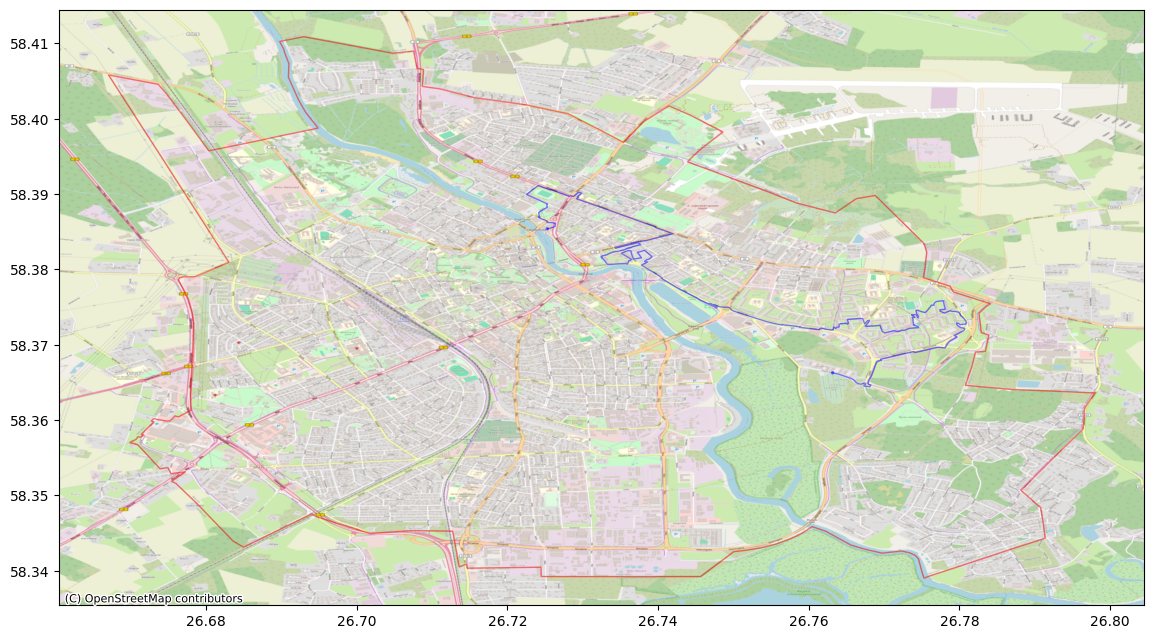

KeyboardInterrupt: ignored

In [ ]:
history = {}
while True:
  bike_type = input("Do you want to use bikeshare or personal bike? Write 'share' or 'personal'.")
  p1 = input("Your start location is: ")
  p2 = input("Your destination: ")

  routes = []
  if bike_type.lower() == 'share':
    share = True
    r_before,route,r_after = route_calculator.calculate_route(p1, p2, share)
    routes = [r_before, route, r_after]
  else:
    share = False
    route = route_calculator.calculate_route(p1, p2, share)
    routes = [route]

  # r_before,route,r_after = route_calculator.calculate_route(p1, p2, share)
  # route_calculator.plot_routes(route)
  travel_time = route_calculator.get_travel_time(routes)
  history[(p1, p2)] = {"route": route, "travel_time": f"{round(travel_time/60, 2)} minutes"}
  print(f"Travel time \nFrom: {p1} \nTo: {p2} \nTime: {round(travel_time/60, 2)} minutes")

  route_calculator.plot_routes(routes)
  time.sleep(10)

In [ ]:
history

In [ ]:
!pip install tk
!export DISPLAY=mymachine.com:0.0

In [ ]:
from tkinter import *
#Create an instance of Tkinter frame or window
win= Tk()
#Set the geometry of tkinter frame
win.geometry("750x250")
def callback():
   Label(win, text="Hello World!", font=('Century 20 bold')).pack(pady=4)
#Create a Label and a Button widget
btn=Button(win, text="Press Enter", command= callback)
btn.pack(ipadx=10)
win.bind('<Return>',lambda event:callback())
win.mainloop()

In [ ]:
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.figure import Figure

# matplotlib plotting inside tkinter window

canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
canvas.draw()
canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()
canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)